In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *

## Load data annotations

In [4]:
path_dataset = Path('/home/florian/projects/toy-jester')
path_videos = Path('/home/florian/projects/toy-jester/20bn-jester-v1')

In [39]:
# Subsample data to smaller dataset for faster experimentation
keep_fraction = 0.1


# Load train and validation CSVs
df_train, df_val = [
    pd.read_csv(
        path_dataset/f'jester-v1-{split}.csv',
        delimiter=';',
        header=None,
        names=['video_id', 'label'])
    for split in ('train', 'validation')
]


# Combine as single dataframe, keep information of data split in "valid" column
df = pd.concat([
    df_train.assign(valid=False).sample(frac=keep_fraction),
    df_val.assign(valid=True).sample(frac=keep_fraction)
], axis=0).reset_index()

df

,index,video_id,label,valid
0,43732,13874,Thumb Down,False
1,76771,108871,Thumb Up,False
2,66434,66842,Swiping Up,False
3,95541,147777,Zooming Out With Two Fingers,False
4,110756,17137,Drumming Fingers,False
...,...,...,...,...
13330,2118,145343,Pushing Two Fingers Away,True
13331,9685,28156,Swiping Left,True
13332,887,140312,Sliding Two Fingers Down,True
13333,13042,123534,Sliding Two Fingers Left,True


## DataBlock setup

In [40]:
def get_x(item):
    # Each video is represented by one frame from the first half of the video
    frames = list((path_videos / str(item['video_id'])).glob('*.jpg'))
    return frames[len(frames)//3]

def get_y(item):
    return item['label']

In [41]:
def splitter(df):
    train = df.index[~df.valid].tolist()
    valid = df.index[df.valid].tolist()
    return train, valid

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=splitter, #RandomSplitter(seed=42),  # splitter
    get_y=get_y,
    get_x=get_x,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=112, max_warp=.05, do_flip=False)
)

## Inspect some samples

In [42]:
dls = datablock.dataloaders(df, shuffle=True)

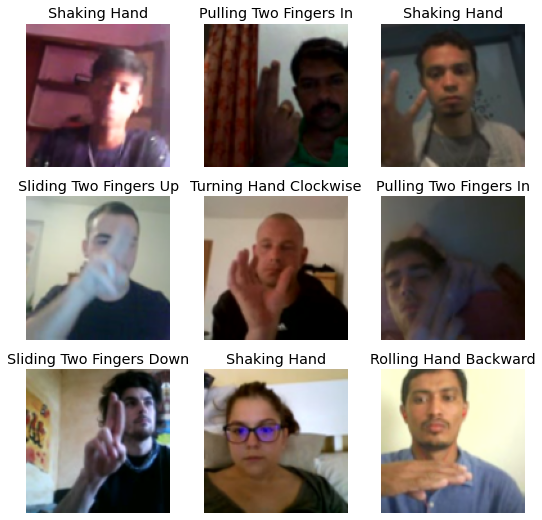

In [43]:
dls.show_batch(nrows=3, ncols=3)

## Create model ("leaner")

In [44]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

## Pick learning rate

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.0964781722577754e-06)

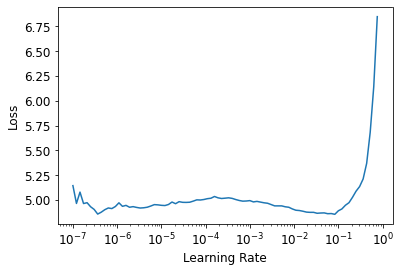

In [45]:
learn.lr_find()

## Training

In [46]:
learn.fine_tune(20, base_lr=1e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,4.788198,3.623165,0.057471,00:10
1,4.145489,3.178830,0.135227,00:10
2,3.744876,3.019707,0.159567,00:10
3,3.371954,2.885281,0.179175,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.062159,2.708437,0.225152,00:12
1,2.855254,2.518595,0.273158,00:12
2,2.627827,2.343120,0.314402,00:12
3,2.441758,2.135156,0.367816,00:12
4,2.225971,1.994618,0.399594,00:12
5,1.997959,1.902538,0.407032,00:13
6,1.820907,1.849673,0.420554,00:13
7,1.698341,1.825721,0.431373,00:13
8,1.580375,1.790367,0.451657,00:13
9,1.448446,1.771343,0.455037,00:13


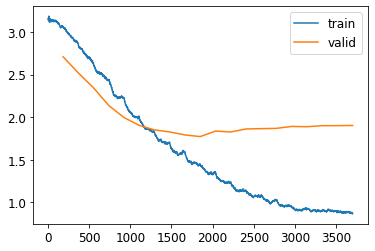

In [47]:
learn.recorder.plot_loss()

## Inspect trained model

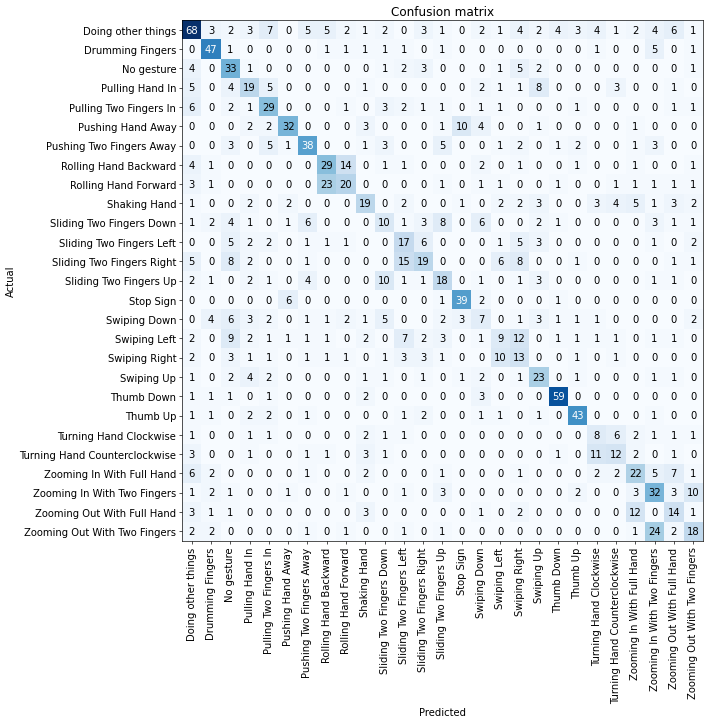

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)